# 一、准备工作
## 1. 指定文件目录

In [1]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os

os.chdir("drive/Colab Notebooks") 
!ls

 com2018.ipynb	     drive		      python基础-task3.ipynb
 data_all.csv	     homework.txt	      授权代码.ipynb
 data.csv	    'one week.ipynb'	      网格搜索调参.ipynb
 data-原始文件.csv   Python基础-task2.ipynb


## 2. 导入需要的包

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelBinarizer, Imputer
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import GridSearchCV


# 二、读取数据并拆分数据集


跑原始文件的时候会有报错：“'utf-8' codec can't decode byte 0xbf in position 0”。  
这是因为数据文件不是utf-8编码格式，所以需要将csv文件另存为utf8 csv格式的，就可以解决该问题。

In [0]:
data_all = pd.read_csv('./data-原始文件.csv',encoding='gbk')
Y = data_all['status']
X = data_all.drop('status', axis=1)

# 按7:3拆分成training和testing集，随机种子为2018。随机种子的目的是使每次拆分的结果一致
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3,random_state=2018)

# 三、数据预处理

## 1. 概览



* 该训练集，一共有89个变量，3327个样本。  
* 很明显第一列没有列名，其实是ID，所以可以直接去掉。  
  
* 数据的缺失值情况还是比较多，在本次情况中数据缺失并不是空值，而是存在大量的NA值。  

* 从数据类型角度来看，有一些object类型的特殊数据。    
  
|列名|情况说明|
| :--- | :--- |
|bank_card_no  | 值里面有很多个???               
|reg_preference_for_trad| 值里面有很多个???
|source| 值都为xs
|id_name|值里面有很多个??? 
|latest_query_time|日期
|loans_latest_time|日期

     那些值里是??的字段直接去掉，source只有一个值，也可直接去掉。


In [4]:
# 总体情况
print(X_train.shape)
X_train.describe()

(3327, 89)


,Unnamed: 0,custid,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
count,3327.000000,3.327000e+03,3325.000000,3325.000000,3327.000000,3325.000000,3325.000000,3325.000000,3325.000000,3321.000000,...,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3112.000000,3107.000000,3112.000000
mean,5998.984070,1.685829e+06,0.022063,0.902433,1946.735798,19.065489,0.806848,0.364448,17.446316,28.980729,...,3386.825193,1818.745501,9186.278920,76.240681,4.716260,5.200835,16082.776350,7993.420308,24.020277,55.572622
std,3449.939393,1.039677e+06,0.041444,0.143441,4113.834226,829.746170,0.196462,0.170165,4.486967,22.315568,...,1473.031960,590.992278,7266.313607,13.989810,2.970034,3.398880,14253.689421,5591.836724,37.305071,53.764925
min,5.000000,1.140000e+02,0.000000,0.000000,0.000000,0.000000,0.120000,0.033000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-2.000000
25%,3102.500000,7.545715e+05,0.010000,0.880000,0.000000,0.600000,0.670000,0.230000,15.000000,16.000000,...,2300.000000,1533.000000,4800.000000,77.000000,2.000000,3.000000,7800.000000,4741.500000,5.000000,10.000000
50%,5960.000000,1.623683e+06,0.010000,0.960000,500.000000,0.970000,0.860000,0.350000,17.000000,24.000000,...,3100.000000,1800.000000,7700.000000,79.000000,4.000000,5.000000,13800.000000,7028.000000,14.000000,36.000000
75%,8998.000000,2.603724e+06,0.020000,0.990000,2000.000000,1.620000,1.000000,0.477000,20.000000,33.000000,...,4300.000000,2100.000000,11700.000000,80.000000,7.000000,7.000000,20400.000000,9944.000000,23.000000,92.250000
max,11992.000000,4.004694e+06,1.000000,1.000000,68000.000000,47596.740000,1.000000,0.941000,41.000000,261.000000,...,9800.000000,5600.000000,87100.000000,87.000000,18.000000,20.000000,266400.000000,70200.000000,359.000000,323.000000


In [5]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3327 entries, 110 to 1274
Data columns (total 89 columns):
Unnamed: 0                                    3327 non-null int64
custid                                        3327 non-null int64
trade_no                                      3327 non-null object
bank_card_no                                  3327 non-null object
low_volume_percent                            3325 non-null float64
middle_volume_percent                         3325 non-null float64
take_amount_in_later_12_month_highest         3327 non-null int64
trans_amount_increase_rate_lately             3325 non-null float64
trans_activity_month                          3325 non-null float64
trans_activity_day                            3325 non-null float64
transd_mcc                                    3325 non-null float64
trans_days_interval_filter                    3321 non-null float64
trans_days_interval                           3325 non-null float64
regional_mobili

In [6]:
# 找出object类型的列
for i in X_train.columns:
    if X_train[i].dtypes == 'object':
        print(i)

trade_no
bank_card_no
reg_preference_for_trad
source
id_name
latest_query_time
loans_latest_time


In [7]:
# 清除第一列和包含???的列
X_train.drop(['Unnamed: 0','id_name', 'bank_card_no', 'reg_preference_for_trad',\
              'latest_query_time', 'loans_latest_time','source'], axis=1, inplace=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


**遇到问题**：  
剩下两个object是日期格式的字段。单纯的日期格式在很多地方都无法直接处理。  
需要对日期做进一步的处理。比如转换成年月日三个单独的数据，或者根据字段具体含义做天数或月数计算，或者直接删除日期字段。  
这些都需要视具体业务知识来定。  
  
在这里偷懒了，为了方便起见，直接删除了。其实转换成距离现在的天数差更好？

## 2. 区分离散变量和连续变量

两种思路：  
一是看变量唯一值个数，先挑选出个数较少的，然后看是否是整数类型。  
二是画每个变量的直方图的，稀疏离散的一般是离散变量 。  
最后再结合字段含义去理解。  

In [8]:
# 查看每个字段唯一值个数
count_value = {}
for col in X_train.columns:
    count_value[col] = len(X_train[col].unique())
sorted(count_value.items(), key=lambda item:item[1])    

[('is_high_user', 2),
 ('student_feature', 3),
 ('regional_mobility', 6),
 ('railway_consume_count_last_12_month', 7),
 ('jewelry_consume_count_last_6_month', 7),
 ('top_trans_count_last_1_month', 9),
 ('avg_consume_less_12_valid_month', 13),
 ('latest_one_month_loan', 14),
 ('trans_fail_top_count_enum_last_1_month', 15),
 ('cross_consume_count_last_1_month', 18),
 ('query_cash_count', 18),
 ('consfin_org_count_behavior', 18),
 ('latest_one_month_suc', 18),
 ('consfin_org_count_current', 18),
 ('rank_trad_1_month', 21),
 ('avg_price_top_last_12_valid_month', 21),
 ('consfin_product_count', 21),
 ('consfin_credibility', 24),
 ('trans_fail_top_count_enum_last_6_month', 25),
 ('loans_credibility_behavior', 25),
 ('loans_overdue_count', 25),
 ('query_finance_count', 26),
 ('trans_fail_top_count_enum_last_12_month', 27),
 ('trans_top_time_last_1_month', 29),
 ('consume_top_time_last_1_month', 29),
 ('latest_three_month_loan', 29),
 ('max_consume_count_later_6_month', 30),
 ('loans_cash_coun

对属性值个数小于10个的进行分析：  
 ('is_high_user', 2)  
 ('student_feature', 3)  
 ('regional_mobility', 6)  
 ('railway_consume_count_last_12_month', 7)  
 ('jewelry_consume_count_last_6_month', 7)  
 ('top_trans_count_last_1_month', 9  
 
 后三个是在过去几个月中的消费/交易计数，统计值，我们认为这是连续数值型属性，不作处理。  
 
 is_high_user的取值是0和1，是离散分类变量。  
 
 student_feature取值是NA、1和2，暂时当做是离散分类变量。

## 3. 变量筛选

一是看变量唯一值的个数，如果只有一种值，肯定不要。  
二是缺失值过多的变量也不要，这里判断依据是缺失值超过2/3。  
三是采用机器学习方法，信息增益等。

In [9]:
# 变量取值个数之前已完成
# 查看缺失值个数

data_isnull = X_train.isnull().sum(axis=0)
data_isnull[data_isnull != 0].sort_values(ascending=False)

student_feature                            2119
cross_consume_count_last_1_month            290
query_finance_count                         220
query_cash_count                            220
latest_six_month_apply                      220
latest_three_month_apply                    220
query_sum_count                             220
latest_one_month_apply                      220
latest_query_day                            220
query_org_count                             220
apply_credibility                           220
apply_score                                 220
latest_one_month_loan                       215
loans_score                                 215
loans_credibility_behavior                  215
loans_count                                 215
loans_settle_count                          215
loans_overdue_count                         215
loans_org_count_behavior                    215
consfin_org_count_behavior                  215
loans_cash_count                        

student_feature 缺失2000多个，直接删除该属性。

In [10]:
X_train.drop(['student_feature'], axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## 4. 缺失值处理

处理NA的情况。由于已经把object数据删除了，所以剩下的数值型数据，都采用均值填充。

In [11]:
imputer = Imputer(strategy='mean')
num = imputer.fit_transform(X_train)
X_train = pd.DataFrame(num, columns=X_train.columns)
X_train.info()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3327 entries, 0 to 3326
Data columns (total 81 columns):
custid                                        3327 non-null float64
trade_no                                      3327 non-null float64
low_volume_percent                            3327 non-null float64
middle_volume_percent                         3327 non-null float64
take_amount_in_later_12_month_highest         3327 non-null float64
trans_amount_increase_rate_lately             3327 non-null float64
trans_activity_month                          3327 non-null float64
trans_activity_day                            3327 non-null float64
transd_mcc                                    3327 non-null float64
trans_days_interval_filter                    3327 non-null float64
trans_days_interval                           3327 non-null float64
regional_mobility                             3327 non-null float64
repayment_capability                          3327 non-null float64
is_high_u

## 5. 数据不平衡处理

本次问题存在类别不平衡问题，原始数据类别间比例约为2.5:1。  
采用SMOTE方法进行过采样处理。

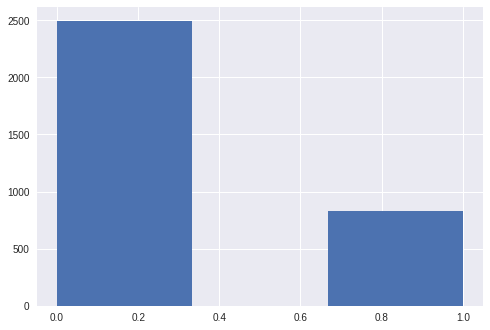

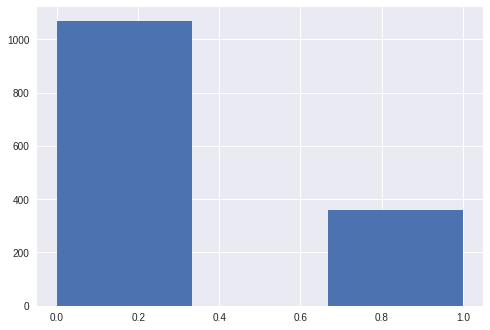

In [12]:
# 查看label的分布，存在数据不平衡问题的。直接初步建模也验证了这一现象。
plt.hist(Y_train, bins=3)
plt.show()
plt.hist(Y_test, bins=3)
plt.show()

In [13]:
over_samples = SMOTE(random_state=2018) 
over_samples_X,over_samples_y = over_samples.fit_sample(X_train, Y_train)

# 重抽样前的类别比例
print(Y_train.value_counts()/len(Y_train))
# 重抽样后的类别比例
print(pd.Series(over_samples_y).value_counts()/len(over_samples_y))

df = pd.DataFrame(over_samples_X)
df.columns = list(X_train[1:0])
over_samples_X = df
over_samples_y = pd.DataFrame(over_samples_y)

0    0.749324
1    0.250676
Name: status, dtype: float64
1    0.5
0    0.5
dtype: float64


# 四、本次遇到问题或后续待处理
1. 日期数据的处理
2. 如何自动区分连续变量和离散变量？
3. 貌似问号是数据编码问题，其实是中文。如果是中文的话，是直接删除还是需要另做处理？怎么做？
4. 缺失值填充，连续变量和离散变量应该分开来处理？
5. 时间原因，变量筛选尚为完成，后续补充

# 特征工程

## IV方法筛选变量
通过信息增益的方法来筛选变量。  
在此之前，需要对连续变量进行离散化处理。  

In [0]:
from sklearn.tree import DecisionTreeClassifier



## 随机森林筛选变量


In [15]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
feat_labels = data_all.columns[1:]

clf = RandomForestClassifier(n_estimators=100, random_state=2018, n_jobs=-1)
clf.fit(over_samples_X, over_samples_y)
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(over_samples_X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


 1) consume_top_time_last_1_month  0.099910
 2) loans_org_count_behavior       0.052795
 3) consume_top_time_last_6_month  0.041965
 4) latest_one_month_apply         0.036360
 5) loans_cash_count               0.031163
 6) pawns_auctions_trusts_consume_last_6_month 0.029163
 7) query_finance_count            0.023588
 8) jewelry_consume_count_last_6_month 0.023496
 9) consfin_org_count_behavior     0.022374
10) avg_consume_less_12_valid_month 0.022077
11) cross_consume_count_last_1_month 0.021784
12) historical_trans_amount        0.015792
13) custid                         0.015296
14) loans_max_limit                0.014784
15) loans_avg_limit                0.013825
16) trans_days_interval_filter     0.013755
17) avg_price_top_last_12_valid_month 0.012181
18) transd_mcc                     0.011632
19) bank_card_no                   0.011481
20) latest_one_month_loan          0.010807
21) historical_trans_day           0.010402
22) max_consume_count_later_6_month 0.010320
23) trans

In [16]:
type(over_samples_X)

pandas.core.frame.DataFrame

In [17]:

# 筛选 重要度>0.01的变量
threshold = 0.01
X_selected = over_samples_X.loc[:, importances > 0.01]
X_selected.shape

(4986, 27)

over_samples_X已经改为了DataFrame格式，所以调用应该用over_samples_X.loc  
如果直接跑over_samples_X[:, importances > 0.01]，会提示报错 `unhashable type: 'slice'``


## 各种模型


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:62: DataConvers

lr
准确率 0.680448493342677
精确率 0.4079696394686907
召回率 0.5988857938718662
F1-score 0.4853273137697516
AUC 0.7162582287461008


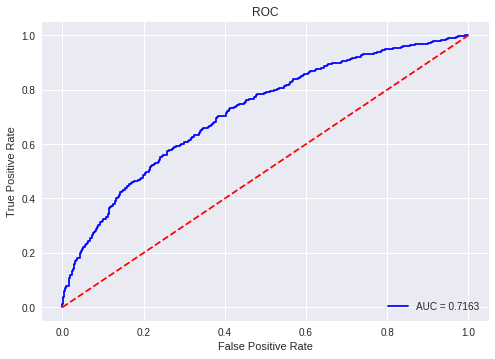

dt
准确率 0.7021723896285914
精确率 0.417910447761194
召回率 0.467966573816156
F1-score 0.44152431011826543
AUC 0.6244327251103252


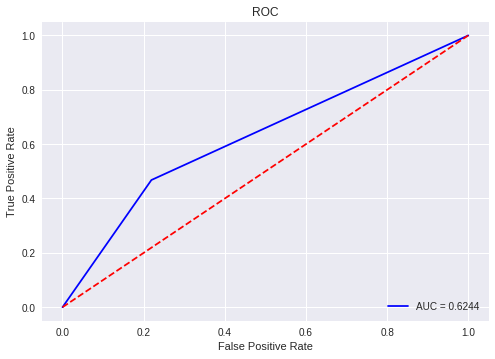

svm_linearSVC
准确率 0.7484232655921513
精确率 0.0
召回率 0.0
F1-score 0.0
AUC 0.5437023358684652


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


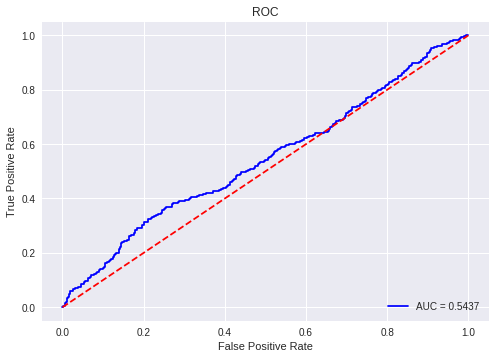

rfc
准确率 0.7764540995094604
精确率 0.5632911392405063
召回率 0.4958217270194986
F1-score 0.5274074074074074
AUC 0.7661771149572786


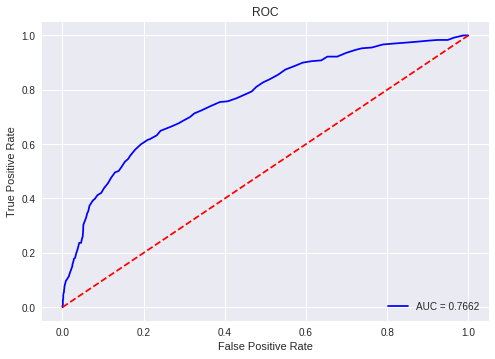

gbc
准确率 0.7694463910301331
精确率 0.5451807228915663
召回率 0.5041782729805014
F1-score 0.5238784370477569
AUC 0.7661419047917123


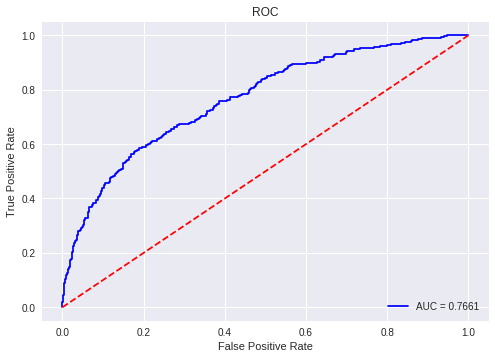

xgb
准确率 0.7736510161177295
精确率 0.5566037735849056
召回率 0.49303621169916434
F1-score 0.5228951255539144
AUC 0.7646396043942287


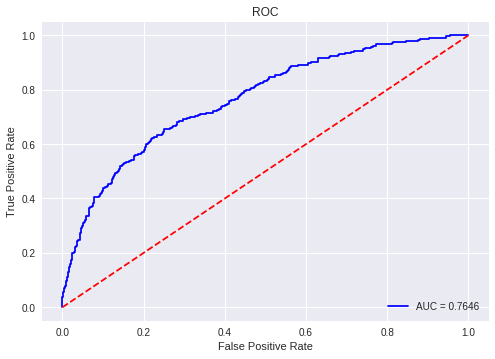

lgbm
准确率 0.7680448493342676
精确率 0.547945205479452
召回率 0.4456824512534819
F1-score 0.4915514592933948
AUC 0.7515675044077911


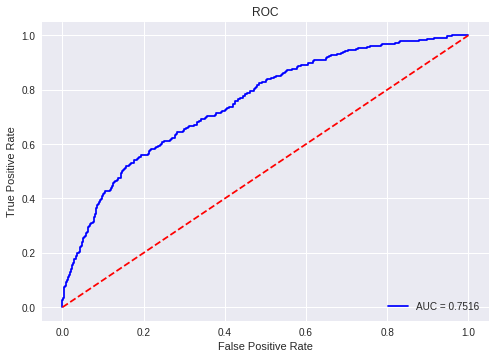

In [19]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 引入要用到的评价函数
from sklearn.metrics import precision_score,roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

# 引入用到的分类算法
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 定义一个包含多个评价指标的函数
def multi_score(model,x_test,y_test):
    test_predict=model.predict(x_test)
    if hasattr(model,'decision_function'):
        pre_test=model.decision_function(x_test)
    else:
        pre_test=model.predict_proba(x_test)[:,1]
    print("准确率",accuracy_score(y_test,test_predict))
    print("精确率",precision_score(y_test,test_predict))
    print("召回率",recall_score(y_test,test_predict))
    print("F1-score",f1_score(y_test,test_predict))
    print("AUC",roc_auc_score(y_test,pre_test))
    false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test,pre_test)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    plt.title('ROC')
    plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.4f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# 依次训练不同分类器
# LogisticRegression
lr = LogisticRegression(random_state =2018)
lr.fit(X_selected, over_samples_y)

# 决策树
dt = DecisionTreeClassifier(random_state=2018)
dt.fit(X_selected, over_samples_y)

# SVM
svm_linearSVC = LinearSVC(random_state=2018)
svm_linearSVC.fit(X_selected, over_samples_y)

# 随机森林
rfc = RandomForestClassifier(n_estimators=100, random_state=2018)
rfc.fit(X_selected, over_samples_y)

# GBDT
gbc = GradientBoostingClassifier(random_state=2018)
gbc.fit(X_selected, over_samples_y)

# xgboost
xgb = XGBClassifier(random_state=2018)
xgb.fit(X_selected, over_samples_y)

# lightgbm
lgbm = LGBMClassifier(random_state=2018)
lgbm.fit(X_selected, over_samples_y)

# 依次对训练好的多个模型用多个指标评价，并画出ROC曲线
X_test.drop(['Unnamed: 0','id_name', 'bank_card_no', 'reg_preference_for_trad', 'latest_query_time', 'loans_latest_time','source','student_feature'], axis=1, inplace=True)
num = imputer.fit_transform(X_test)
X_test = pd.DataFrame(num, columns=X_test.columns)
X_test = X_test.iloc[:, importances > 0.01]

model_name = ["lr", "dt", "svm_linearSVC", "rfc", "gbc", "xgb", "lgbm"]
for name in model_name:
    model = eval(name)
    print(name)
    multi_score(model, X_test, Y_test)

    

# 任务二思考及遇到的问题
1. X_train和X_test的数据要严格一致，属性数、缺失值等。所以应该在原始全部数据上做预处理，然后在拆分成训练集、测试集。
2. 对数据不平衡处理后，数据标签丢失。导致在xgb中特征名称不匹配，跑不出结果  
3. IV没有找到很好的结果办法，待改进  
  
针对对题2，已解决。  
smote方法后，丢失了列名并且数据格式转成了array。  
所以将其重新传换为Dataframe格式，并且添加列名。  
代码如下：  
  
```
df = pd.DataFrame(over_samples_X)
df.columns = list(X_train[1:0])
over_samples_X = df
over_samples_y = pd.DataFrame(over_samples_y)
```

# 任务三 模型融合
首先介绍一款功能强大的stacking利器，mlxtend库，它可以很快地完成对sklearn模型地stacking。  

**StackingClassifier 使用API及参数解析：**
  
```
StackingClassifier(classifiers, meta_classifier, use_probas=False, average_probas=False, verbose=0, use_features_in_secondary=False)
```
  
**参数：**

* classifiers : 基分类器，数组形式，[cl1, cl2, cl3]. 每个基分类器的属性被存储在类属性 self.clfs_.  
* meta_classifier : 目标分类器，即将前面分类器合起来的分类器  
* use_probas : bool (default: False) ，如果设置为True， 那么目标分类器的输入就是前面分类输出的类别概率值而不是类别标签  
* average_probas : bool (default: False)，用来设置上一个参数当使用概率值输出的时候是否使用平均值。  
* verbose : int, optional (default=0)。用来控制使用过程中的日志输出，当 verbose = 0时，什么也不输出， verbose = 1，输出回归器的序号和名字。verbose = 2，输出详细的参数信息。verbose > 2, 自动将verbose设置为小于2的，verbose -2.  
* use_features_in_secondary : bool (default: False). 如果设置为True，那么最终的目标分类器就被基分类器产生的数据和最初的数据集同时训练。如果设置为False，最终的分类器只会使用基分类器产生的数据训练。  
  
**属性：**  
* clfs_ : 每个基分类器的属性，list, shape 为 [n_classifiers]。  
* meta_clf_ : 最终目标分类器的属性  
 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/l

准确率 0.7021723896285914
精确率 0.417910447761194
召回率 0.467966573816156
F1-score 0.44152431011826543
AUC 0.6886247691778036


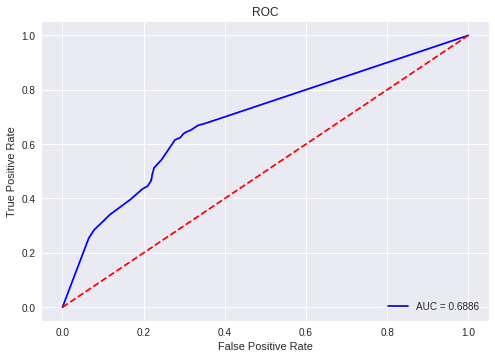

In [25]:
# stacking模型
stack = StackingClassifier(classifiers=[lr, dt, gbc, xgb, lgbm], use_probas=True,
                          average_probas=False,
                          meta_classifier=rfc)

stack.fit(X_selected, over_samples_y)
multi_score(stack, X_test, Y_test)

报错：AttributeError: 'LinearSVC' object has no attribute 'predict_proba'    
暂时不用这个模型。。。  

rfc  
准确率 0.7764540995094604  
精确率 0.5632911392405063  
召回率 0.4958217270194986  
F1-score 0.5274074074074074  
AUC 0.7661771149572786  

stack
准确率 0.7021723896285914  
精确率 0.417910447761194  
召回率 0.467966573816156  
F1-score 0.44152431011826543  
AUC 0.6886247691778036  

除了F1有略微提升，其他指标都不如初始的rfc。  

## 参考资料
[stacking 的基本思想及代码实现] https://goo.gl/JkmffM  
[StackingClassifier官方文档] https://goo.gl/69gAM8  
[如何在 Kaggle 首战中进入前 10%] https://goo.gl/VgjxDq